# Complexity Lexicon Construction

## (1.0) Load Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 500)

In [2]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')
ModelEmbed = namedtuple('ModelEmbed', 'type, name, dimension, corpus, model')
Result = namedtuple('Result', 'dataset, fc, measure')
Lexicon = namedtuple('Lexicon', 'name, epochs, thresh_l, thresh_r, agg_embed, lexicon')

In [3]:
from nltk import word_tokenize

columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]

def load_df(path, d_type, header):
    df = pd.read_csv(path, header=header, sep = "\t")
    if len(df.columns) == len(columns):
        df.columns = columns
    if d_type == 'word':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))<=1,]
    elif d_type == 'phrase':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))>1,]
    return df

def load_datasets(names, train_name, test_name, type_train = None, type_test = None, header=None):
    MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
    datasets = [Dataset(name, load_df(MAIN_PATH_DATASET + name + '_' + train_name + '.tsv', type_train, header),
                              load_df(MAIN_PATH_DATASET + name + '_' + test_name + '.tsv', type_test, header))
                              for name in names]
    return datasets

## (1.1) Load Embedding Models

### (1.1.1) Load GloVe embeddings

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

def get_embedding_models_glove():
    glove_defs = [#ModelEmbed('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
                  #ModelEmbed('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
                  ModelEmbed('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None),
                  ModelEmbed('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
                  ModelEmbed('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None)]
                  #ModelEmbed('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
                  #ModelEmbed('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
                 #ModelEmbed('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None),
                  #ModelEmbed('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None),
                  #ModelEmbed('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

    models = []
    for model in glove_defs:
        glove_file = datapath(MAIN_PATH + model.name)
        tmp_file = get_tmpfile(model.name + '-temp')
        glove2word2vec(glove_file, tmp_file)
        vecs = KeyedVectors.load_word2vec_format(tmp_file)
        models.append(ModelEmbed(model.type, model.name, model.dimension, model.corpus, vecs))
        print('load model : {}'.format(model.name))
    return models

C:\Users\Studio\Anaconda3\lib\site-packages\gensim-3.5.0-py3.6-win-amd64.egg\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### (1.1.2) Load word2vec embeddings

In [5]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

def get_embedding_models_word2vec():
    return ModelEmbed('word2vec', 'GoogleNews-vectors-negative300.bin' , 300, 'GoogleNews', \
            KeyedVectors.load_word2vec_format(datapath(MAIN_PATH + 'GoogleNews-vectors-negative300.bin'), binary=True))

### (1.1.3) Load FastText embeddings

In [6]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

def get_embedding_models_fasttext():
    return ModelEmbed('FastText', 'wiki.en.vec', 300, 'Wikipedia', \
                 KeyedVectors.load_word2vec_format(MAIN_PATH + 'wiki.en.vec'))

## (2) Boostrapped Lexicon Construction

### (2.1) Baseline

In [7]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

'''
Extract all words that are exactly identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are neglected for the vocabulary
'''
def build_clean_vocabulary(train):
    targets_complex = set([mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

'''
Extract all words that are identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are weighted based on the number
of occurrences. If the word has been tagged more times as non-complex
we save it as non-complex otherwise it is complex
'''
def build_weighted_vocabulary(train):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_1(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] < confidence,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_2(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_mean(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).mean().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary

def build_confidence_vocabulary_max(train):
    train['target'] = train.target.apply(lambda target : target.strip().lower())
    agg = train[['target', 'prob']].groupby('target',
                        as_index=False).max().values
    tuples = [tuple(val) for val in agg]
    vocabulary = {}
    for target, confidence in tuples:
        vocabulary[target] = confidence
    return vocabulary
    

def evaluate_label_target_predictions(test, vocabulary):
    dict_test = list(zip(test.target, test.binary))
    data = [(binary, (vocabulary[target.strip().lower()] if target.strip().lower() in vocabulary else 1)) 
            for target, binary in dict_test]
    y_true = [vals[0] for vals in data]
    prediction = [vals[1] for vals in data]
    return precision_recall_fscore_support(y_true, prediction, average='macro')

In [8]:
def baseline_vocab_clean(datasets):
    evaluation_clean = [Result(ds.name, 'vocab_clean', 
                    evaluate_label_target_predictions(ds.test, 
                    build_clean_vocabulary(ds.train))) for ds in datasets]
    results_clean = [{'dataset' : result.dataset, 
                        'zc' : result.fc, 'prec' : result.measure[0],
                  'rec' : result.measure[1], 'f1' : result.measure[2]} 
                       for result in evaluation_clean]
    return pd.DataFrame.from_records(results_clean)

In [9]:
def baseline_vocab_weighted(datasets):
    evaluation_weighted = [Result(ds.name, 'vocab_weighted', 
                        evaluate_label_target_predictions(ds.test, 
                    build_weighted_vocabulary(ds.train))) for ds in datasets]
    results_weighted = [{'dataset' : result.dataset, 
                        'zc' : result.fc, 'prec' : result.measure[0],
                  'rec' : result.measure[1], 'f1' : result.measure[2]} 
                       for result in evaluation_weighted]
    return pd.DataFrame.from_records(results_weighted)

In [10]:
def baseline_vocab_conf(datasets, confidence = 0.5):
    evaluation_conf = [Result(ds.name, 'vocab_conf',
                            evaluate_label_target_predictions(ds.test, 
                        build_confidence_vocabulary_2(ds.train, confidence))) for ds in datasets]
    results_conf = [{'dataset' : result.dataset, 
                        'zc' : result.fc, 'prec' : result.measure[0],
                  'rec' : result.measure[1], 'f1' : result.measure[2]} 
                       for result in evaluation_conf]
    return pd.DataFrame.from_records(results_conf)

### (2.2) Boostrapping Lexicon

In [37]:
def ngram_embedding_similarity(model, word_l, word_r, missing_strat, ngram_repr):
    vecs_l = [model[word.strip().lower()] if word.strip().lower() in model.vocab 
                  else missing_strat(word, model.vector_size) 
                  for word in word_l.split()]   
    vecs_r = [model[word.strip().lower()] if word.strip().lower() in model.vocab \
                else missing_strat(word, model.vector_size)
                for word in word_r.split()]
    vec_l = ngram_repr(np.array(vecs_l), [word.strip().lower()
                  for word in word_l.split()])
    vec_r = ngram_repr(np.array(vecs_r), [word.strip().lower()
                  for word in word_r.split()])
    return np.dot(vec_l,vec_r) / (np.linalg.norm(vec_l) \
            * np.linalg.norm(vec_r))

In [12]:
def bootstrap_lexicon(model, vocab, seeds_l, seeds_r, embedding_sim, \
                      missing_strat, ref_term, ngram_repr, agg_embed=True, epochs=10, \
                      bound_l=-1, bound_r=1, thresh_l=-0.5,thresh_r=0.5):
    if not all(seed in vocab for seed in seeds_l):
        raise ValueError('Not all left seeds contained in vocabulary')
    if not all(seed in vocab for seed in seeds_r):
        raise ValueError('Not all right seeds contained in vocabulary')
    num_missing = np.sum([np.sum([1 for word in mwe.split()
                        if word.strip().lower() not in model.vocab]) for mwe in vocab])
    print('Missing vocab in model : {} / {}%'.format(num_missing, \
          (num_missing/len(vocab)*100)))
    if agg_embed:
        internal_vocab = vocab
    else:
        internal_vocab = [word for mwe in vocab for word in mwe.split()]
    # 1. Initialize the left and right seeds
    se_l = {seed : bound_l for seed in seeds_l}
    se_r = {seed : bound_r for seed in seeds_r}
    lexicon = se_l.copy()
    lexicon.update(se_r)
    for curr_epoch in range(1,epochs+1):
        # 2. Compute left and right weights
        print(se_l)
        sum_l = np.abs(np.sum([score for word, score in se_l.items()]))
        sum_r = np.abs(np.sum([score for word, score in se_r.items()]))
        weight_l = sum_r / (sum_r + sum_l)
        weight_r = sum_l / (sum_r + sum_l)
        print(sum_l)
        print(sum_r)
        print('Epoch {} : Se_l_size = {}, Se_r_size = {}, weight_l = {}, weight_r = {},'.format(\
                      curr_epoch, len(se_l), len(se_r), weight_l, weight_r))
        for index, curr_word in enumerate(internal_vocab):
            if((index % 500) == 0):
                print('{}|{}:{}%   '.format(index, len(internal_vocab), 
                                    (index/len(internal_vocab))), end='')
            if curr_word in se_l or curr_word in se_r:
                continue
            # Compute the weighted left and right scores and sum them
            score_l = [(weight_l * score * \
                        embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)) \
                        for seed, score in se_l.items()]
            score_r = [(weight_r * score * \
                        embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)) \
                        for seed, score in se_r.items()]
            print('Word : {}'.format(curr_word))
            print(score_r)
            print(score_l)
            score = np.sum(score_l) + np.sum(score_r)
            print('final score : {}'.format(score))
            lexicon[curr_word] = score
            print('{} : {}'.format(curr_word, score))
            # Add word to the seed set if the score is low or high enough
            if score <= thresh_l: se_l[curr_word] = score
            if score >= thresh_r: se_r[curr_word] = score
        #print(lexicon)
    # 3. Compute final scores and normalize them
    sim_ref = lexicon.get(ref_term)
    #print('SIM_REF:{}'.format(sim_ref))
    if not sim_ref:
        return ValueError('Reference term {} not found in lexicon'.format(ref_term))
    coll_l = {seed : (score - sim_ref) for seed, score in lexicon.items() \
                if (score - sim_ref) < 0}
    coll_r = {seed : (score - sim_ref) for seed, score in lexicon.items() \
                if (score - sim_ref) > 0}
    max_l = np.max(np.abs([score for _, score in coll_l.items()]))
    max_r = np.max(np.abs([score for _, score in coll_r.items()]))
    #print(coll_l)
    #print(max_l)
    lexicon[ref_term] = lexicon[ref_term] - sim_ref
    for word, score in coll_l.items():
        lexicon[word] = score / max_l
    for word, score in coll_r.items():
        lexicon[word] = score / max_r
    # 4. Aggregate MWE complexity scores
    if not agg_embed:
        for mwe in vocab:
            lexicon[mwe] = np.mean([lexicon[word] for word in mwe.split()])
    return lexicon



def bootstrap_lexicon_average(models, vocab, seeds_l, seeds_r, embedding_sim, \
                      missing_strat, ref_term, ngram_repr, agg_embed=True, epochs=10, \
                      bound_l=-1, bound_r=1, thresh_l=-0.5,thresh_r=0.5):
    if not all(seed in vocab for seed in seeds_l):
        raise ValueError('Not all left seeds contained in vocabulary')
    if not all(seed in vocab for seed in seeds_r):
        raise ValueError('Not all right seeds contained in vocabulary')
    num_missing = np.sum([np.sum([1 for word in mwe.split()
                        if word.strip().lower() not in model[0].vocab]) for mwe in vocab])
    print('Missing vocab in models : {} / {}%'.format(num_missing, \
          (num_missing/len(vocab)*100)))
    if agg_embed:
        internal_vocab = vocab
    else:
        internal_vocab = [word for mwe in vocab for word in mwe.split()]
    # 1. Initialize the left and right seeds
    se_l = {seed : bound_l for seed in seeds_l}
    se_r = {seed : bound_r for seed in seeds_r}
    internal_lexicon = se_l.copy()
    internal_lexicon.update(se_r)
    for curr_epoch in range(1,epochs+1):
        print('Epoch {} : Se_l_size = {}, Se_r_size = {}'.format(\
                      curr_epoch, len(se_l), len(se_r)))
        for index, curr_word in enumerate(internal_vocab):
            if((index % 500) == 0):
                print('{}|{}:{}%   '.format(index, len(internal_vocab), 
                                    (index/len(internal_vocab))), end='')
            if curr_word in se_l or curr_word in se_r:
                continue
            # Compute the weighted left and right scores and sum them
            score_l = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr) 
                                for model in models])) \
                        for seed, score in se_l.items()]
            score_r = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)
                                for model in models])) \
                        for seed, score in se_r.items()]
            #print('Word : {}'.format(curr_word))
            #print(score_r)
            #print(score_l)
            score = np.mean(score_l) + np.mean(score_r)
            #print('final score : {}'.format(score))
            internal_lexicon[curr_word] = score
            #print('{} : {}'.format(curr_word, score))
            # Add word to the seed set if the score is low or high enough
            if score <= thresh_l: se_l[curr_word] = score
            if score >= thresh_r: se_r[curr_word] = score
        #print(lexicon)
    # 3. Compute final scores and normalize them
    sim_ref = internal_lexicon.get(ref_term)
    print('SIM_REF:{}'.format(sim_ref))
    if not sim_ref:
        return ValueError('Reference term {} not found in lexicon'.format(ref_term))
    coll_l = {seed : (score - sim_ref) for seed, score in internal_lexicon.items() \
                if (score - sim_ref) < 0}
    coll_r = {seed : (score - sim_ref) for seed, score in internal_lexicon.items() \
                if (score - sim_ref) > 0}
    max_l = np.max(np.abs([score for _, score in coll_l.items()]))
    max_r = np.max(np.abs([score for _, score in coll_r.items()]))
    #print(coll_l)
    #print(max_l)
    internal_lexicon[ref_term] = internal_lexicon[ref_term] - sim_ref
    for word, score in coll_l.items():
        internal_lexicon[word] = score / max_l
    for word, score in coll_r.items():
        internal_lexicon[word] = score / max_r
    # 4. Aggregate MWE complexity scores
    lexicon = {}
    for word in vocab:
        tokens = word.split()
        if len(tokens) > 1 and not agg_embed:
            lexicon[word] = np.mean([internal_lexicon[token] 
                                     for token in tokens])
        else:
            lexicon[word] = internal_lexicon[word]
    return lexicon

def bootstrap_lexicon_average_no_ref(models, vocab, seeds_l, seeds_r, embedding_sim, \
                      missing_strat, ngram_repr, agg_embed=True, epochs=10, \
                      bound_l=-1, bound_r=1, thresh_l=-0.5,thresh_r=0.5):
    if not all(seed in vocab for seed in seeds_l):
        raise ValueError('Not all left seeds contained in vocabulary')
    if not all(seed in vocab for seed in seeds_r):
        raise ValueError('Not all right seeds contained in vocabulary')
    num_missing = np.sum([np.sum([1 for word in mwe.split()
                        if word.strip().lower() not in model[0].vocab]) for mwe in vocab])
    print('Missing vocab in models : {} / {}%'.format(num_missing, \
          (num_missing/len(vocab)*100)))
    if agg_embed:
        internal_vocab = vocab
    else:
        internal_vocab = [word for mwe in vocab for word in mwe.split()]
    # 1. Initialize the left and right seeds
    se_l = {seed : bound_l for seed in seeds_l}
    se_r = {seed : bound_r for seed in seeds_r}
    internal_lexicon = se_l.copy()
    internal_lexicon.update(se_r)
    for curr_epoch in range(1,epochs+1):
        print('Epoch {} : Se_l_size = {}, Se_r_size = {}'.format(\
                      curr_epoch, len(se_l), len(se_r)))
        for index, curr_word in enumerate(internal_vocab):
            if((index % 500) == 0):
                print('{}|{}:{}%   '.format(index, len(internal_vocab), 
                                    (index/len(internal_vocab))), end='')
            if curr_word in se_l or curr_word in se_r:
                continue
            # Compute the weighted left and right scores and sum them
            score_l = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr) 
                                for model in models])) \
                        for seed, score in se_l.items()]
            score_r = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)
                                for model in models])) \
                        for seed, score in se_r.items()]
            #print('Word : {}'.format(curr_word))
            #print(score_r)
            #print(score_l)
            score = np.mean(score_l) + np.mean(score_r)
            #print('final score : {}'.format(score))
            internal_lexicon[curr_word] = score
            #print('{} : {}'.format(curr_word, score))
            # Add word to the seed set if the score is low or high enough
            if score <= thresh_l: se_l[curr_word] = score
            if score >= thresh_r: se_r[curr_word] = score
        #print(lexicon)
    # 4. Aggregate MWE complexity scores
    lexicon = {}
    for word in vocab:
        tokens = word.split()
        if len(tokens) > 1 and not agg_embed:
            lexicon[word] = np.mean([internal_lexicon[token] 
                                     for token in tokens])
        else:
            lexicon[word] = internal_lexicon[word]
    return lexicon

In [14]:
import pylab as pl

def search_best_threshold(y_true, prediction, border_l=-0.1, border_r=0.1, step_size=0.00001):
    best_f1 = -1
    best_scores = None
    best_threshold = 0
    print('Testing {} steps'.format(len(pl.frange(border_l, border_r, step_size))))
    for step in pl.frange(border_l, border_r, step_size):
        scores = precision_recall_fscore_support(y_true, list(map(lambda val: \
                                    1 if val>-step else 0, prediction)), average='macro')
        if scores[0] > best_f1: 
            best_f1 = scores[0]
            best_scores = scores
            best_threshold = step
    return best_scores, best_threshold

In [15]:
import numpy
from sklearn.metrics import precision_recall_fscore_support

def compute_y_test_and_predictions(lexicon, dataset):
    pairs = construct_pairs(lexicon.lexicon, dataset.test)
    y_true = [pair[1] for pair in pairs]
    prediction = [pair[2] for pair in pairs]
    print(len(y_true))
    print(len(prediction))
    print('Verified Test/Prediction lengths OK : {}'.format((len(y_true)==len(prediction))))
    return y_true, prediction

In [16]:
def construct_pairs(lexicon, df_test):
    dict_test = list(zip(df_test.target, df_test.binary))
    return [(target, binary, lexicon[target.strip().lower()]) 
            for target, binary in dict_test]

## (3) Toy-Example Lexicon

In [13]:
models = get_embedding_models_glove()

load model : glove.6B.50d.txt
load model : glove.6B.100d.txt
load model : glove.6B.200d.txt


### (3.1) Single Model with reference term and score aggregation

In [17]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad', 'worse', 'unfortunately', 'really']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

model = [models[0].model]
ref_term = 'and'
lexicon = bootstrap_lexicon_average(model, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, ref_term, \
                  ngram_repr_bow_mean, agg_embed=False, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad', 'worse', 'unfortunately', 'really']
---------Vocabulary----------------
['aboriginal', 'bad', 'worse', 'unfortunately', 'really', 'good', 'inuit', 'and', 'to this end']
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 4, Se_r_size = 1
0|11:0.0%   Epoch 2 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   Epoch 3 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   SIM_REF:-0.33638048225707995
{'aboriginal': 1.0, 'bad': -1.0, 'worse': -1.0, 'unfortunately': -1.0, 'really': -1.0, 'good': -0.43517536551322916, 'inuit': 0.8350315056510479, 'and': 0.0, 'to this end': -0.266093955672061}


### (3.2) Single Model and score aggregation

In [18]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad', 'worse', 'unfortunately', 'really']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

model = [models[0].model]
lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, \
                  ngram_repr_bow_mean, agg_embed=False, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad', 'worse', 'unfortunately', 'really']
---------Vocabulary----------------
['aboriginal', 'bad', 'worse', 'unfortunately', 'really', 'good', 'inuit', 'and', 'to this end']
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 4, Se_r_size = 1
0|11:0.0%   Epoch 2 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   Epoch 3 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   {'aboriginal': 1, 'bad': -1, 'worse': -1, 'unfortunately': -1, 'really': -1, 'good': -0.625171348452568, 'inuit': 0.7795393239647231, 'and': -0.33638048225707995, 'to this end': -0.512965624794479}


### (3.3) Multiple Models with reference term and score aggregation

In [19]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end', 'extraordinary'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

models_selected = [model.model for model in models]
ref_term = 'and'
lexicon = bootstrap_lexicon_average(models_selected, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, ref_term, \
                  ngram_repr_bow_mean, agg_embed=False, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad']
---------Vocabulary----------------
['aboriginal', 'bad', 'good', 'inuit', 'and', 'to this end', 'extraordinary']
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 1, Se_r_size = 1
0|9:0.0%   Epoch 2 : Se_l_size = 2, Se_r_size = 2
0|9:0.0%   Epoch 3 : Se_l_size = 2, Se_r_size = 2
0|9:0.0%   SIM_REF:-0.3394447895207775
{'aboriginal': 1.0, 'bad': -1.0, 'good': -0.44711642938187895, 'inuit': 0.7827501611049796, 'and': 0.0, 'to this end': -0.10329034693032661, 'extraordinary': 0.023338522950455867}


### (3.4) Single Model with reference term and embedding aggregation

In [20]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad', 'worse', 'unfortunately', 'really']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

model = [models[0].model]
ref_term = 'and'
lexicon = bootstrap_lexicon_average(model, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, ref_term, \
                  ngram_repr_bow_mean, agg_embed=True, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad', 'worse', 'unfortunately', 'really']
---------Vocabulary----------------
['aboriginal', 'bad', 'worse', 'unfortunately', 'really', 'good', 'inuit', 'and', 'to this end']
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 4, Se_r_size = 1
0|9:0.0%   Epoch 2 : Se_l_size = 6, Se_r_size = 2
0|9:0.0%   Epoch 3 : Se_l_size = 6, Se_r_size = 2
0|9:0.0%   SIM_REF:-0.36147909368740827
{'aboriginal': 1.0, 'bad': -1.0, 'worse': -1.0, 'unfortunately': -1.0, 'really': -1.0, 'good': -0.41297356462134016, 'inuit': 0.8380726688661927, 'and': 0.0, 'to this end': -0.31752104683715165}


## (4) Complexity Lexicon for CWI

In [ ]:
models = get_embedding_models_glove()

In [21]:
datasets = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Dev', type_train='word', type_test='word')

## (4.0) Baseline

In [30]:
baseline_vocab_clean(datasets)

,dataset,f1,prec,rec,zc
0,Wikipedia,0.644488,0.714126,0.680523,vocab_clean
1,WikiNews,0.691826,0.735392,0.741662,vocab_clean
2,News,0.726351,0.755768,0.786249,vocab_clean


In [32]:
baseline_vocab_weighted(datasets)

,dataset,f1,prec,rec,zc
0,Wikipedia,0.673146,0.721375,0.700415,vocab_weighted
1,WikiNews,0.734567,0.749724,0.768554,vocab_weighted
2,News,0.828990,0.820062,0.846029,vocab_weighted


In [33]:
baseline_vocab_conf(datasets)

,dataset,f1,prec,rec,zc
0,Wikipedia,0.673272,0.706433,0.694744,vocab_conf
1,WikiNews,0.722976,0.725654,0.744031,vocab_conf
2,News,0.778589,0.785862,0.772903,vocab_conf


## (4.1) Results

In [57]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=True
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = datasets

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    vocabulary.append(ref_term)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 1454
Target non-complex : 1426
---------Testing Seeds----------------
Target test : 606
Missing vocab in models : 132.0 / 3.7854889589905363%
Epoch 1 : Se_l_size = 1426, Se_r_size = 1454
0|3487:0.0%   500|3487:0.14338973329509608%   1000|3487:0.28677946659019216%   1500|3487:0.43016919988528823%   2000|3487:0.5735589331803843%   2500|3487:0.7169486664754804%   3000|3487:0.8603383997705765%   -----------------------------------------
-----------------------------------------
Dataset :WikiNews
---------Training Targets----------------
Targets complex : 1548
Target non-complex : 1543
---------Testing Seeds----------------
Target test : 776
Missing vocab in models : 109.0 / 2.8179937952430194%
Epoch 1 : Se_l_size = 1543, Se_r_size = 1548
0|3868:0.0%   500|3868:0.12926577042399173%   1000|3868:0.25853154084798347%   1500|3868:0.38

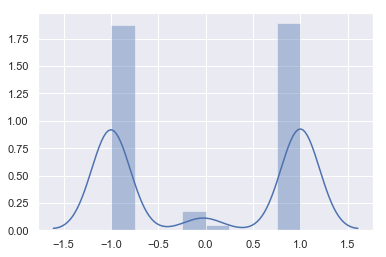

In [106]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [112]:
# Wikipedia
y_true, prediction = compute_y_test_and_predictions(lexicons[0], datasets[0])
scores_wiki, best_t_wiki = search_best_threshold(y_true, prediction)
print('Wikipedia : Scores = {}, Best T. = {}'.format(scores_wiki, best_t_wiki))

# WikiNews
y_true, prediction = compute_y_test_and_predictions(lexicons[1], datasets[1])
scores_wikinews, best_t_wikinews = search_best_threshold(y_true, prediction)
print('WikiNews : Scores = {}, Best T. = {}'.format(scores_wikinews, best_t_wikinews))

# News
y_true, prediction = compute_y_test_and_predictions(lexicons[2], datasets[2])
scores_news, best_t_news = search_best_threshold(y_true, prediction)
print('News : Scores = {}, Best T. = {}'.format(scores_news, best_t_news))

606
606
Verified Test/Prediction lengths OK : True
Testing 20001 steps


C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: numpy.arange
  import sys
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: numpy.arange
  


Wikipedia : Scores = (0.7403267973856209, 0.74414319703425, 0.7397327351561326, None), Best T. = 0.05327000000000001
776
776
Verified Test/Prediction lengths OK : True
Testing 20001 steps


C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: numpy.arange
  import sys
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: numpy.arange
  


WikiNews : Scores = (0.7948717948717949, 0.8068981631259211, 0.7994116271340825, None), Best T. = 0.03337000000000001
1502
1502
Verified Test/Prediction lengths OK : True
Testing 20001 steps


C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: numpy.arange
  import sys
C:\Users\Studio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: numpy.arange
  


News : Scores = (0.8500761941044812, 0.8557917238041461, 0.8528016448263172, None), Best T. = 0.03548000000000001


# (5) Complexity Lexicon for CPI

In [ ]:
models = get_embedding_models_glove()

In [29]:
datasets = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Dev', type_train='both', type_test='phrase')

### (5.1) MWE with Embedding Aggregation

Here, we first select the seed sets based on majority voting in cases of tie from the training data, then we compute the lexicons for each domain. Afterwards, we find the best threshold to split between non-complex and complex words.

In [38]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=True
embedding_sim = ngram_embedding_similarity
ngram_repr = lambda wordvecs, words : ngram_repr_wiki_weighted_bow(wordvecs, words, 0.001, ngram_repr_bow_mean)
missing_strat = missing_strat_random
model = [model.model for model in models]
data = datasets

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 88
Missing vocab in models : 184.0 / 5.020463847203274%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|3665:0.0%   500|3665:0.1364256480218281%   1000|3665:0.2728512960436562%   1500|3665:0.4092769440654843%   2000|3665:0.5457025920873124%   2500|3665:0.6821282401091405%   3000|3665:0.8185538881309686%   3500|3665:0.9549795361527967%   -----------------------------------------
-----------------------------------------
Dataset :WikiNews
---------Training Targets----------------
Targets complex : 2221
Target non-complex : 1764
---------Testing Seeds----------------
Target test : 94
Missing vocab in models : 172.0 / 4.216719784260848%
Epoch 1 : Se_l_size = 1764, Se_r_size = 2221
0|4079:0.0%   500|4079:0.12257906349595489%   1000|4079:0.2451581269

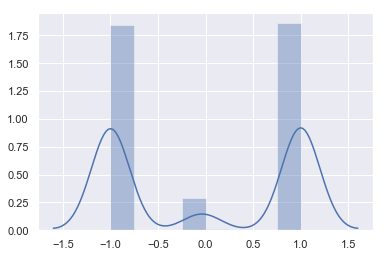

In [22]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Wikipedia
    y_true, prediction = compute_y_test_and_predictions(lexicons[0], datasets[0])
    scores_wiki, best_t_wiki = search_best_threshold(y_true, prediction)
    print('Wikipedia : Scores = {}, Best T. = {}'.format(scores_wiki, best_t_wiki))

    # WikiNews
    y_true, prediction = compute_y_test_and_predictions(lexicons[1], datasets[1])
    scores_wikinews, best_t_wikinews = search_best_threshold(y_true, prediction)
    print('WikiNews : Scores = {}, Best T. = {}'.format(scores_wikinews, best_t_wikinews))

    # News
    y_true, prediction = compute_y_test_and_predictions(lexicons[2], datasets[2])
    scores_news, best_t_news = search_best_threshold(y_true, prediction)
    print('News : Scores = {}, Best T. = {}'.format(scores_news, best_t_news))

88
88
Verified Test/Prediction lengths OK : True
Testing 20001 steps
Wikipedia : Scores = (0.6744186046511628, 0.528957528957529, 0.51875, None), Best T. = 0.08828
94
94
Verified Test/Prediction lengths OK : True
Testing 20001 steps
WikiNews : Scores = (0.8870967741935484, 0.5227272727272727, 0.4798418972332016, None), Best T. = 0.07144
262
262
Verified Test/Prediction lengths OK : True
Testing 20001 steps
News : Scores = (0.6685076889755253, 0.5674410540915396, 0.5720861172976985, None), Best T. = 0.03426000000000001


In [40]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=True
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = datasets

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 88
Missing vocab in models : 184.0 / 5.020463847203274%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|3665:0.0%   500|3665:0.1364256480218281%   1000|3665:0.2728512960436562%   1500|3665:0.4092769440654843%   2000|3665:0.5457025920873124%   2500|3665:0.6821282401091405%   3000|3665:0.8185538881309686%   3500|3665:0.9549795361527967%   -----------------------------------------
-----------------------------------------
Dataset :WikiNews
---------Training Targets----------------
Targets complex : 2221
Target non-complex : 1764
---------Testing Seeds----------------
Target test : 94
Missing vocab in models : 172.0 / 4.216719784260848%
Epoch 1 : Se_l_size = 1764, Se_r_size = 2221
0|4079:0.0%   500|4079:0.12257906349595489%   1000|4079:0.2451581269

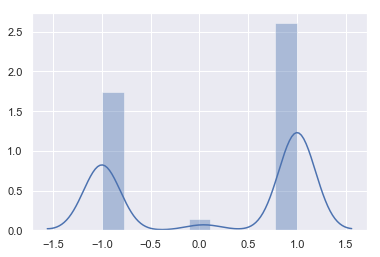

In [41]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Wikipedia
    y_true, prediction = compute_y_test_and_predictions(lexicons[0], datasets[0])
    scores_wiki, best_t_wiki = search_best_threshold(y_true, prediction)
    print('Wikipedia : Scores = {}, Best T. = {}'.format(scores_wiki, best_t_wiki))

    # WikiNews
    y_true, prediction = compute_y_test_and_predictions(lexicons[1], datasets[1])
    scores_wikinews, best_t_wikinews = search_best_threshold(y_true, prediction)
    print('WikiNews : Scores = {}, Best T. = {}'.format(scores_wikinews, best_t_wikinews))

    # News
    y_true, prediction = compute_y_test_and_predictions(lexicons[2], datasets[2])
    scores_news, best_t_news = search_best_threshold(y_true, prediction)
    print('News : Scores = {}, Best T. = {}'.format(scores_news, best_t_news))

88
88
Verified Test/Prediction lengths OK : True
Testing 20001 steps
Wikipedia : Scores = (0.5875, 0.5540540540540541, 0.24649714582252205, None), Best T. = -0.0932
94
94
Verified Test/Prediction lengths OK : True
Testing 20001 steps
WikiNews : Scores = (0.8870967741935484, 0.5227272727272727, 0.4798418972332016, None), Best T. = 0.04645000000000002
262
262
Verified Test/Prediction lengths OK : True
Testing 20001 steps
News : Scores = (0.5968253968253968, 0.5211511789181692, 0.4972872833134842, None), Best T. = 0.004680000000000004


### (4.2) MWE with Embedding Aggregation and Reference Term

In [314]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=True
ref_term = 'and'
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = [datasets[0]]

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    vocabulary.append(ref_term)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, ref_term=ref_term, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 694
Missing vocab in models : 201.0 / 4.705056179775281%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|4272:0.0%   500|4272:0.11704119850187265%   1000|4272:0.2340823970037453%   1500|4272:0.351123595505618%   2000|4272:0.4681647940074906%   2500|4272:0.5852059925093633%   3000|4272:0.702247191011236%   3500|4272:0.8192883895131086%   4000|4272:0.9363295880149812%   SIM_REF:-0.05605420319279125


C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


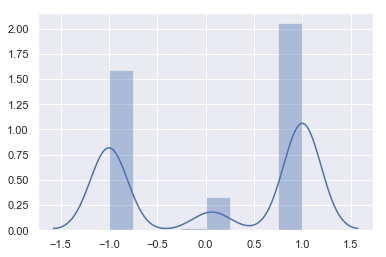

In [315]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [316]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [318]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
prediction = [pair[2] for pair in pairs]
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-1 else 0, prediction)))

0.746987951807229

### (4.3) MWE with Complexity Score Aggregation no reference term

In [32]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=False
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = datasets

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    print('and' in vocabulary)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

False
-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 88
Missing vocab in models : 184.0 / 5.020463847203274%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|4774:0.0%   500|4774:0.10473397570171764%   1000|4774:0.20946795140343527%   1500|4774:0.31420192710515293%   2000|4774:0.41893590280687054%   2500|4774:0.5236698785085881%   3000|4774:0.6284038542103059%   3500|4774:0.7331378299120235%   4000|4774:0.8378718056137411%   4500|4774:0.9426057813154587%   False
-----------------------------------------
-----------------------------------------
Dataset :WikiNews
---------Training Targets----------------
Targets complex : 2221
Target non-complex : 1764
---------Testing Seeds----------------
Target test : 94
Missing vocab in models : 172.0 / 4.216719784260848%
Epoch 1 : Se_l_size = 1764, Se_r_

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Wikipedia
    y_true, prediction = compute_y_test_and_predictions(lexicons[0], datasets[0])
    scores_wiki, best_t_wiki = search_best_threshold(y_true, prediction)
    print('Wikipedia : Scores = {}, Best T. = {}'.format(scores_wiki, best_t_wiki))

    # WikiNews
    y_true, prediction = compute_y_test_and_predictions(lexicons[1], datasets[1])
    scores_wikinews, best_t_wikinews = search_best_threshold(y_true, prediction)
    print('WikiNews : Scores = {}, Best T. = {}'.format(scores_wikinews, best_t_wikinews))

    # News
    y_true, prediction = compute_y_test_and_predictions(lexicons[2], datasets[2])
    scores_news, best_t_news = search_best_threshold(y_true, prediction)
    print('News : Scores = {}, Best T. = {}'.format(scores_news, best_t_news))

88
88
Verified Test/Prediction lengths OK : True
Testing 20001 steps
Wikipedia : Scores = (0.5684210526315789, 0.6254826254826256, 0.5359801488833746, None), Best T. = 0.023000000000000007
94
94
Verified Test/Prediction lengths OK : True
Testing 20001 steps
WikiNews : Scores = (0.5342730790491984, 0.5391414141414141, 0.4132334581772784, None), Best T. = -0.1
262
262
Verified Test/Prediction lengths OK : True
Testing 20001 steps
News : Scores = (0.5807453416149069, 0.6183252427184466, 0.5616188724881136, None), Best T. = 0.001920000000000005


C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


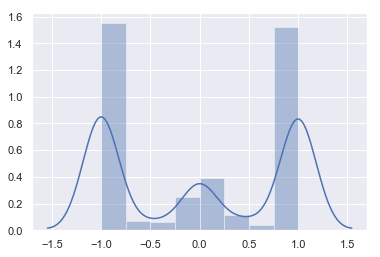

In [180]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [224]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [225]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
prediction = [pair[2] for pair in pairs]
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-0.7 else 0, prediction)))

694
694


0.7403055229142186

### (4.4) MWE with Complexity Score Aggregation no reference term (weighted seeds)

In [323]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=False
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = [datasets[0]]

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    print('and' in vocabulary)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

False
-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 694
Missing vocab in models : 201.0 / 4.7061578084757665%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|5380:0.0%   500|5380:0.09293680297397769%   1000|5380:0.18587360594795538%   1500|5380:0.2788104089219331%   2000|5380:0.37174721189591076%   2500|5380:0.4646840148698885%   3000|5380:0.5576208178438662%   3500|5380:0.6505576208178439%   4000|5380:0.7434944237918215%   4500|5380:0.8364312267657993%   5000|5380:0.929368029739777%   

C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


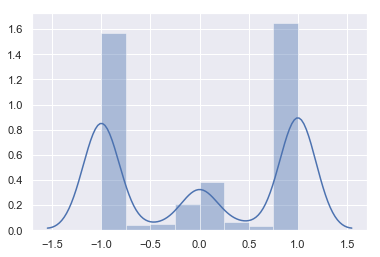

In [324]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [325]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [326]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
prediction = [pair[2] for pair in pairs]
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-0.7 else 0, prediction)))

0.7463768115942029

### (4.5) MWE with particular Model

In [335]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=False
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [models[3].model]
data = [datasets[0]]

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    print('and' in vocabulary)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

False
-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 694
Missing vocab in models : 206.0 / 4.823226410676656%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|5380:0.0%   500|5380:0.09293680297397769%   1000|5380:0.18587360594795538%   1500|5380:0.2788104089219331%   2000|5380:0.37174721189591076%   2500|5380:0.4646840148698885%   3000|5380:0.5576208178438662%   3500|5380:0.6505576208178439%   4000|5380:0.7434944237918215%   4500|5380:0.8364312267657993%   5000|5380:0.929368029739777%   

C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


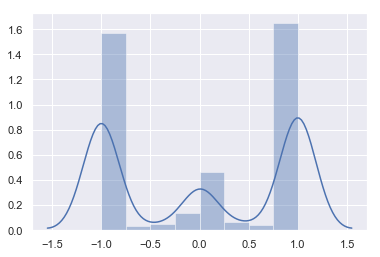

In [336]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [337]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [338]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
prediction = [pair[2] for pair in pairs]
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-1 else 0, prediction)))

0.7463768115942029